In [2]:
# Wyłączenie ostrzerzeń w ramach skryptu
options(warn = -1)

# Zimportowanie bibliotek
library(BCA)
library(relimp)
library(car)
library(RcmdrMisc)
library(sqldf)

Loading required package: carData

Loading required package: sandwich

Loading required package: gsubfn

Loading required package: proto

Loading required package: RSQLite



In [3]:
# Zaimportowanie zbioru bank
Bank <-read.csv("http://jolej.linuxpl.info/bank.csv", header=TRUE, sep = ";")

In [4]:
# Tworzenie zbioru walidacyjnego i estymacyjnego
Bank$Sample <- create.samples(Bank, est = 0.7, val = 0.3)

In [5]:
# Obejrzyj zbi?r zobacz nowo dodana zmiena Sample
showData(Bank)

In [6]:
# Utworzenie zmiennej numerycznej na podstawie zmiennej czynnikowej y
Bank <- within(Bank, {
  y.Num <- Recode(y, '"yes"=1; "no"=0', as.factor=FALSE)
})

In [ ]:
# Wykres rozkladu zmiennych
scatterplot(y.Num~balance, reg.line=lm, smooth=TRUE, 
            id.n = 2, boxplots='xy', span=0.5, data=Bank)

In [8]:
# Przedzialowsanie zmiennej numerycznej
Bank$balance.cat <- with(Bank, bin.var(balance, bins=4, method='proportions',
                                       labels=NULL))

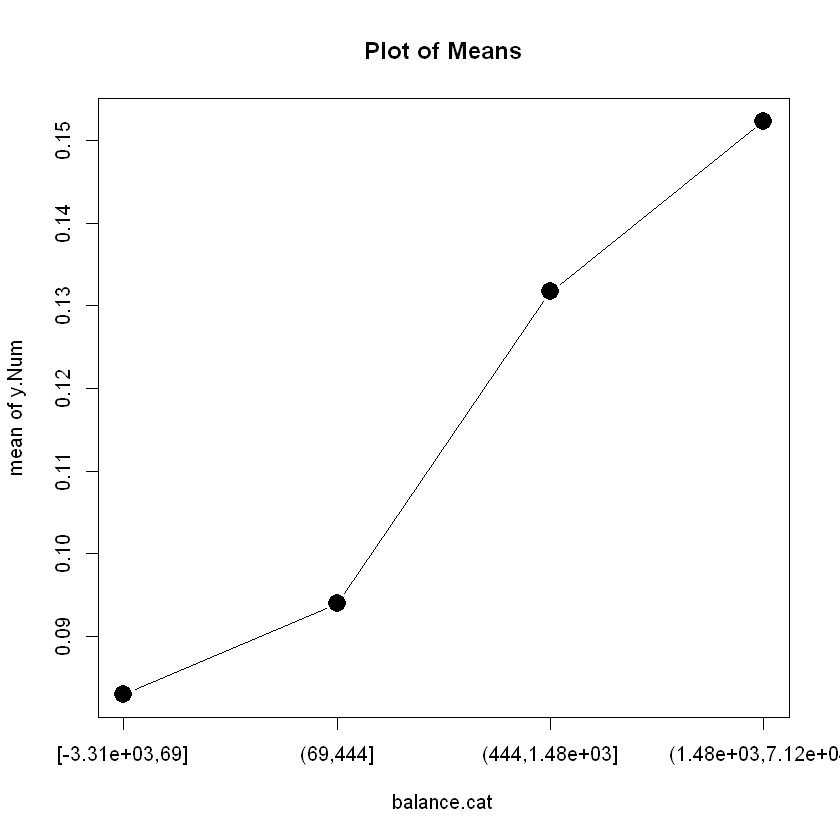

In [10]:
# Wykres srednich dla balance.cat
with(Bank, plotMeans(y.Num, balance.cat, error.bars="none"))

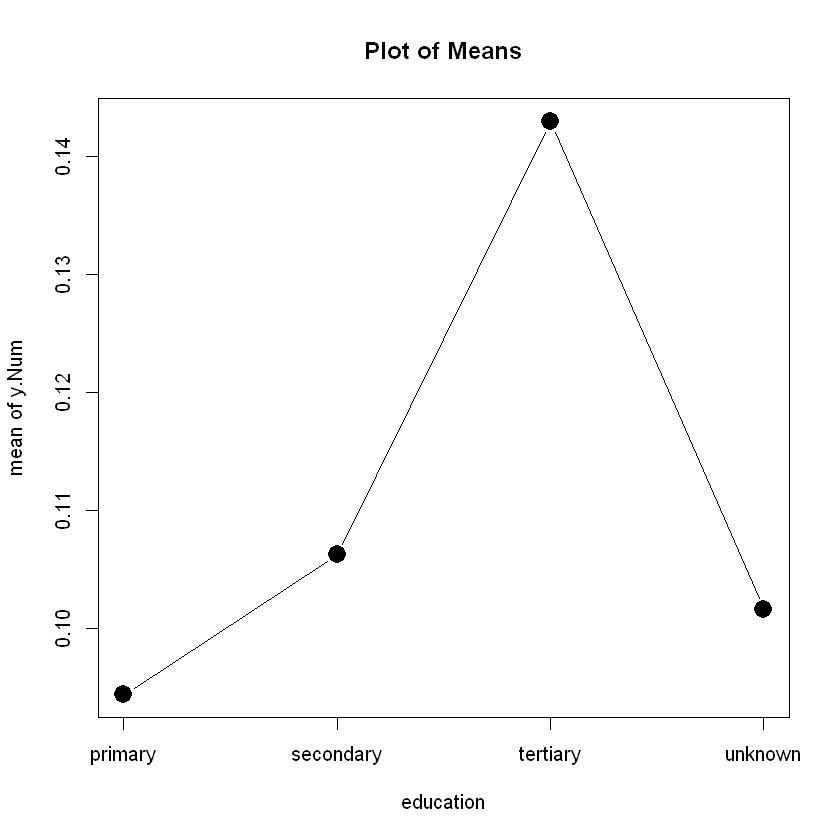

In [12]:
# Wykres srednich dla zmiennej education
with(Bank, plotMeans(y.Num, education, error.bars="none"))

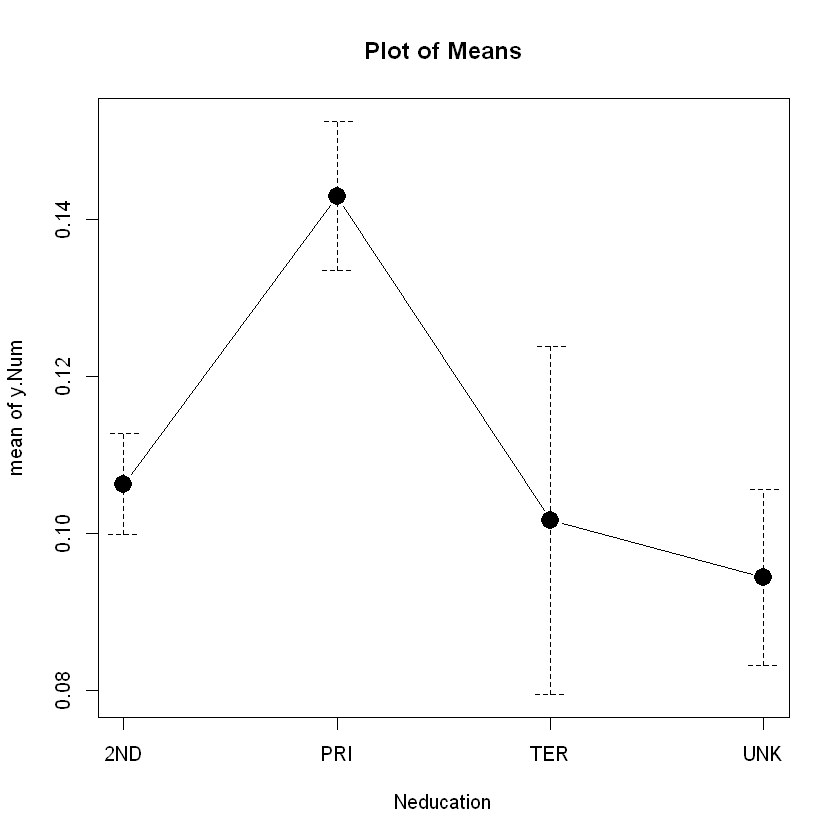

In [14]:
#Przeorganizowanie poziom?w dla zmienej education
Bank$Neducation <- relabel.factor(factor(Bank$education), new.labels=c('UNK','2ND','PRI','TER'))
with(Bank, plotMeans(y.Num, Neducation))

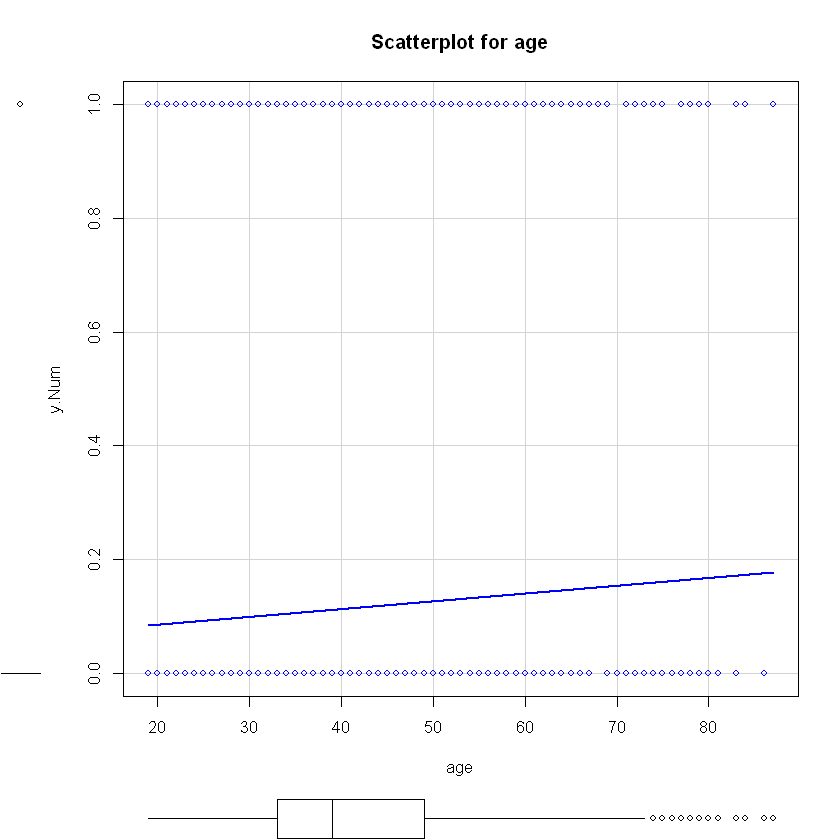

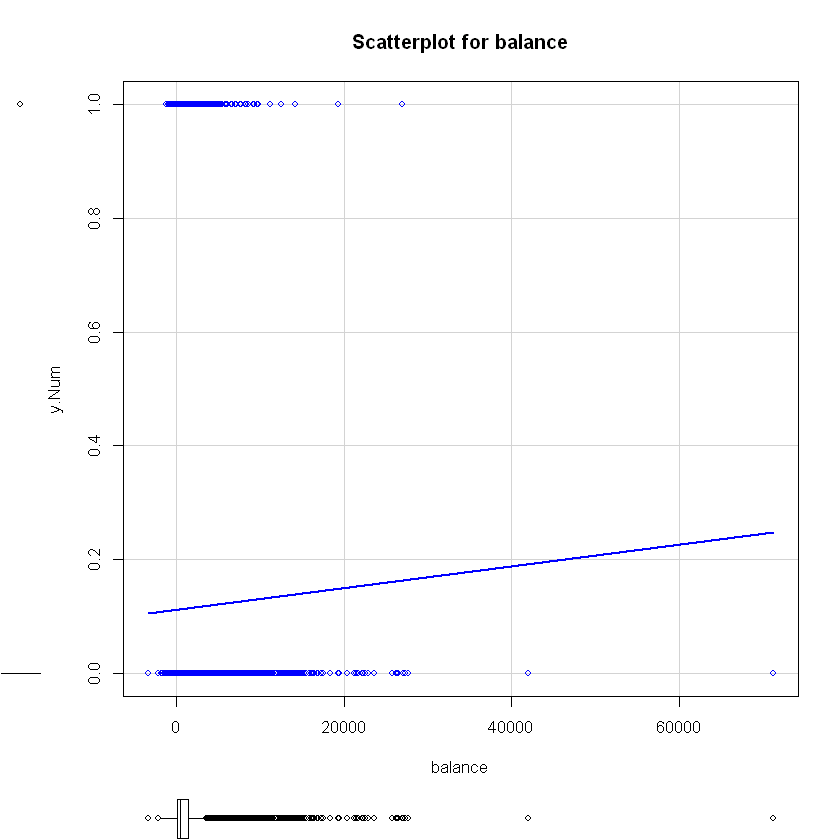

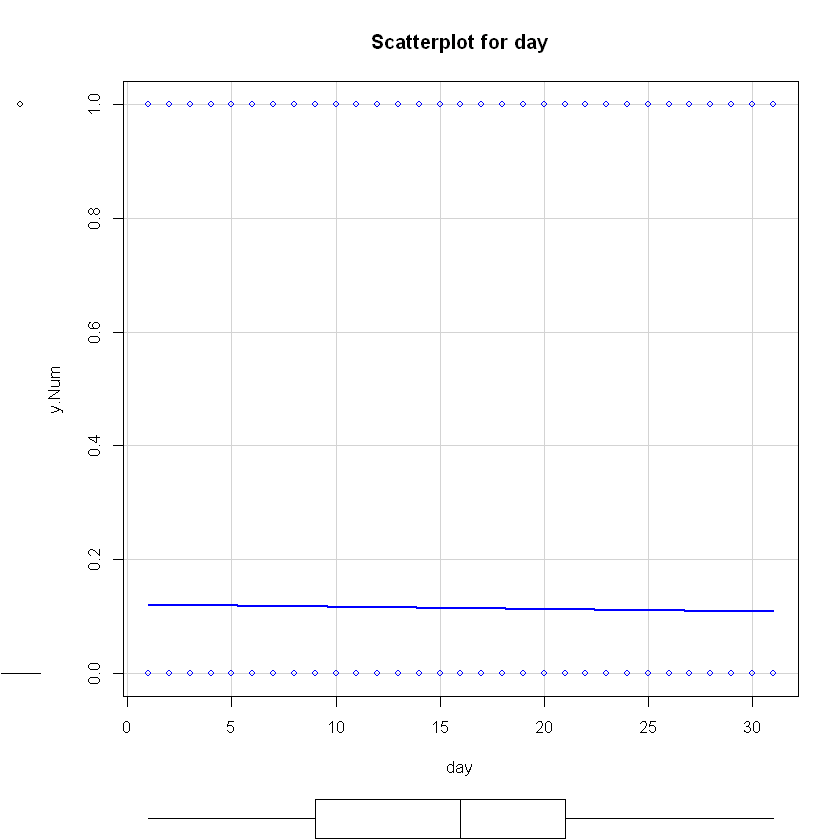

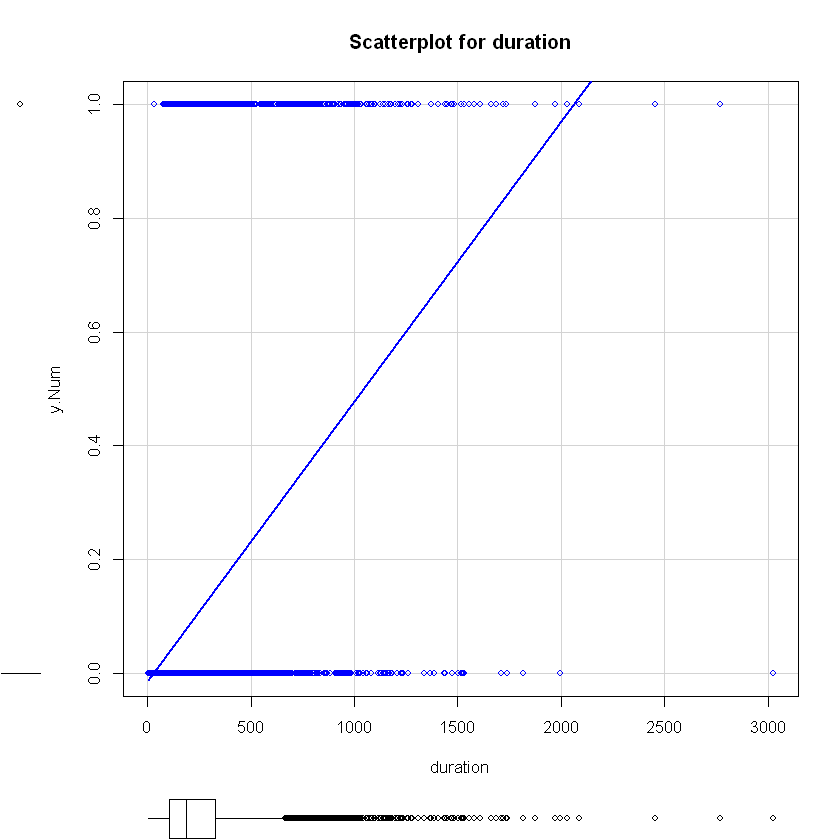

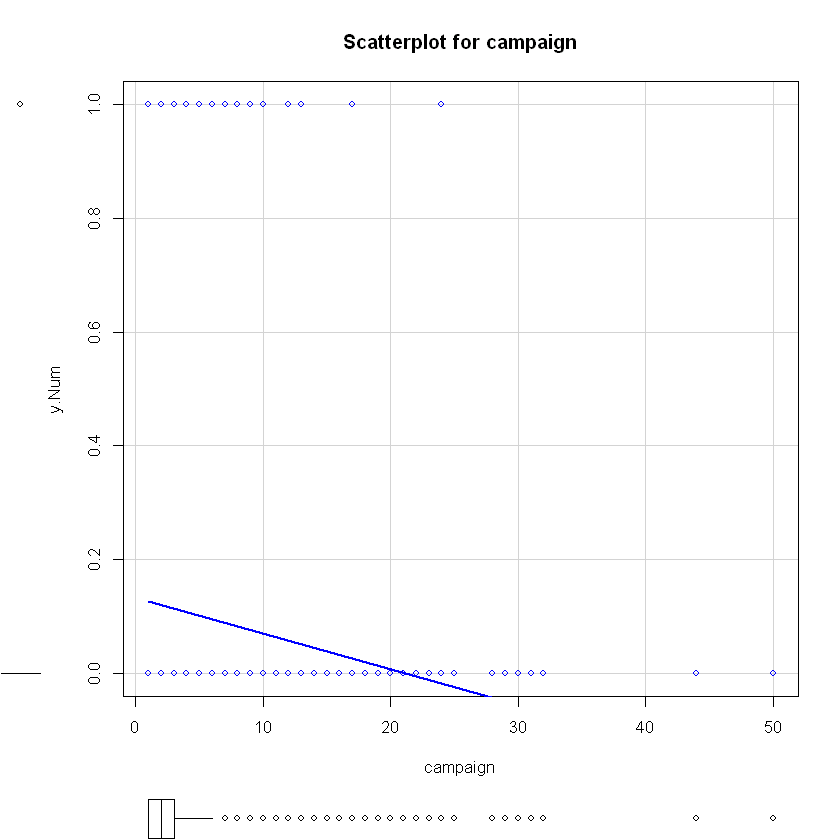

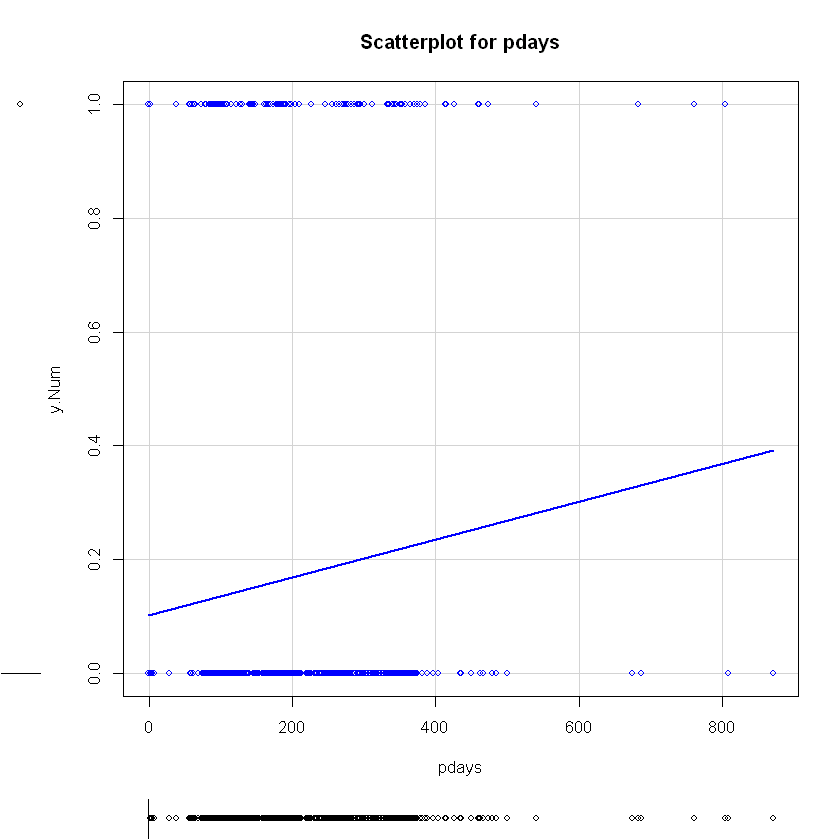

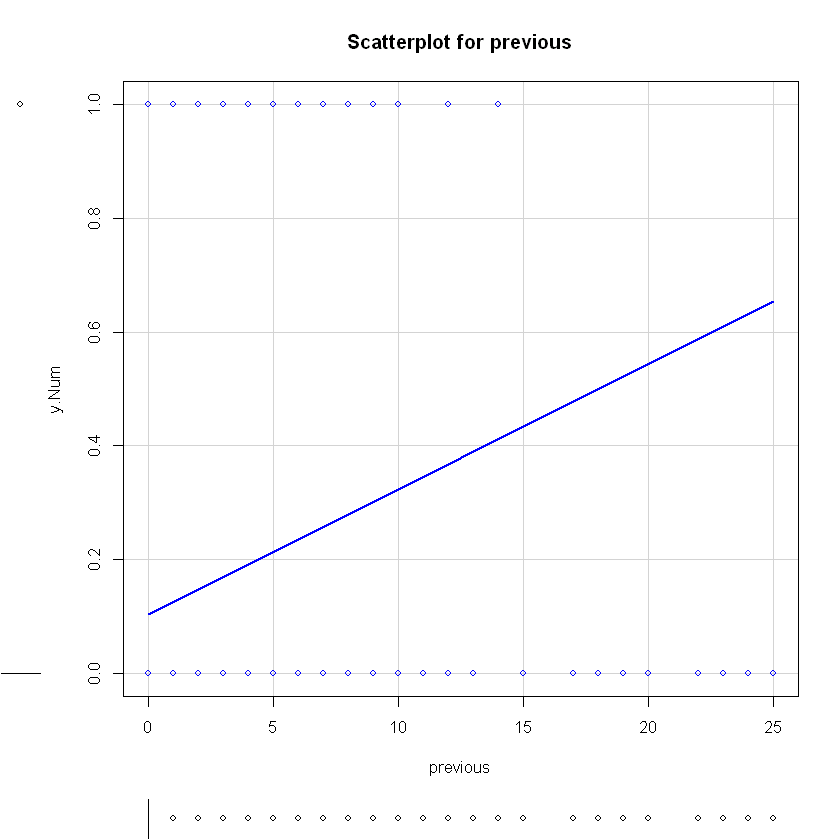

In [16]:
# Sprawdz rodzaj zaleznosci (liniowa nieliniowa dla pozostalych zmiennych numerycznych
numeric_vars <- setdiff(names(Bank)[sapply(Bank, is.numeric)], "y.Num")
for (var in numeric_vars) {
  scatterplot(as.formula(paste("y.Num ~", var)), reg.line = lm, smooth = TRUE, 
              id.n = 2, boxplots = "xy", span = 0.5, data = Bank,
              main = paste("Scatterplot for", var))
}

In [18]:
# Analizując wykresy wszystkie zmienne wyglądają na zależność nieliniową
# Nie da się wyznaczyć linii trendu

In [20]:
# Uog?lniony model liniowy
GLM.2 <- glm(y.Num ~ age + job + marital + education + default + balance +
               housing + loan + contact + day + month + duration + campaign +
               pdays + previous + poutcome, family=binomial(logit), data=Bank)
summary(GLM.2)


Call:
glm(formula = y.Num ~ age + job + marital + education + default + 
    balance + housing + loan + contact + day + month + duration + 
    campaign + pdays + previous + poutcome, family = binomial(logit), 
    data = Bank)

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)        -2.462e+00  6.038e-01  -4.077 4.55e-05 ***
age                -4.232e-03  7.125e-03  -0.594 0.552537    
jobblue-collar     -3.924e-01  2.420e-01  -1.621 0.104937    
jobentrepreneur    -2.498e-01  3.811e-01  -0.655 0.512199    
jobhousemaid       -3.530e-01  4.176e-01  -0.845 0.398000    
jobmanagement      -7.302e-02  2.407e-01  -0.303 0.761602    
jobretired          6.315e-01  3.112e-01   2.029 0.042454 *  
jobself-employed   -1.812e-01  3.533e-01  -0.513 0.608167    
jobservices        -1.457e-01  2.729e-01  -0.534 0.593542    
jobstudent          3.784e-01  3.750e-01   1.009 0.312958    
jobtechnician      -1.926e-01  2.301e-01  -0.837 0.402496    
jobunemploye

In [22]:
# Wsp?lczynnik R2 McFaddena
1 - (GLM.2$deviance/GLM.2$null.deviance) # McFadden R2

[1] 0.3272513

In [24]:
# Budowa modelu nieliniowego

In [26]:
# sprawdzanie czy zmienne nie posiadaja wartosci zerowych
colSums(Bank==0)

age         job     marital   education     default     balance 
          0           0           0           0           0         357 
    housing        loan     contact         day       month    duration 
          0           0           0           0           0           0 
   campaign       pdays    previous    poutcome           y      Sample 
          0           0        3705           0           0           0 
      y.Num balance.cat  Neducation 
       4000           0           0

In [28]:
# W przypadku zmiennej previous uzywamy log(X+n)
Bank$LogAge <- with(Bank, log(age))
Bank$LogDay <- with(Bank, log(day))
Bank$LogDuration <- with(Bank, log(duration))
Bank$LogCampaign <- with(Bank, log(campaign))
Bank$LogPrevious <- with(Bank, log(previous+4))

In [30]:
# Tworzenie modelu nieliniowego
LogBank <- glm(y.Num ~ LogAge + LogDay + LogDuration + 
                 LogCampaign + LogCampaign + LogPrevious, family=binomial(logit), 
              data=Bank, subset=Sample=="Estimation")
summary(LogBank)
1 - (LogBank$deviance/LogBank$null.deviance) # McFadden R2


Call:
glm(formula = y.Num ~ LogAge + LogDay + LogDuration + LogCampaign + 
    LogCampaign + LogPrevious, family = binomial(logit), data = Bank, 
    subset = Sample == "Estimation")

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -14.60818    1.15223 -12.678  < 2e-16 ***
LogAge        0.33217    0.24391   1.362   0.1732    
LogDay       -0.10108    0.08950  -1.129   0.2587    
LogDuration   1.70761    0.09230  18.501  < 2e-16 ***
LogCampaign  -0.23618    0.09836  -2.401   0.0163 *  
LogPrevious   1.43796    0.20782   6.919 4.54e-12 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 2283.3  on 3164  degrees of freedom
Residual deviance: 1736.1  on 3159  degrees of freedom
AIC: 1748.1

Number of Fisher Scoring iterations: 6


[1] 0.2396416

In [32]:
# Sprawdzanie istotnosci zmiennych czynnikowych
Anova(LogBank)

,LR Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>
LogAge,1.854074,1,1.733103e-01
LogDay,1.259159,1,2.618103e-01
LogDuration,482.833630,1,5.166018e-107
LogCampaign,5.924595,1,1.493097e-02
LogPrevious,45.068791,1,1.902331e-11


In [34]:
#  Budowa modelu mieszanego

In [36]:
MixedBank <- glm(y.Num ~ LogAge + job + marital + education + default + balance +
                   housing + loan + contact + LogDay + month + LogDuration + LogCampaign +
                   pdays + LogPrevious + poutcome, family=binomial(logit), data=Bank, 
                subset=Sample=="Estimation")
summary(MixedBank)
1 - (MixedBank$deviance/MixedBank$null.deviance) # McFadden R2


Call:
glm(formula = y.Num ~ LogAge + job + marital + education + default + 
    balance + housing + loan + contact + LogDay + month + LogDuration + 
    LogCampaign + pdays + LogPrevious + poutcome, family = binomial(logit), 
    data = Bank, subset = Sample == "Estimation")

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)        -1.308e+01  1.838e+00  -7.116 1.11e-12 ***
LogAge             -1.775e-01  3.624e-01  -0.490 0.624150    
jobblue-collar     -4.389e-01  2.936e-01  -1.495 0.134967    
jobentrepreneur    -4.189e-01  4.414e-01  -0.949 0.342647    
jobhousemaid       -7.653e-02  5.135e-01  -0.149 0.881524    
jobmanagement      -3.335e-02  3.022e-01  -0.110 0.912144    
jobretired          7.205e-01  3.746e-01   1.923 0.054433 .  
jobself-employed   -5.386e-02  4.272e-01  -0.126 0.899682    
jobservices         1.078e-01  3.240e-01   0.333 0.739329    
jobstudent          3.151e-01  4.890e-01   0.644 0.519371    
jobtechnician      -2.108e

[1] 0.3706552